- 1 Introduction
- 2 Load and check data
    - 2.1 load data
    - 2.2 Outlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
- 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical values
- 4 Filling missing Values
    - 4.1 Age
- 5 Feature engineering
    - 5.1 Name/Title
    - 5.2 Family Size
    - 5.3 Cabin
    - 5.4 Ticket
- 6 Modeling
    - 6.1 Simple modeling
        - 6.1.1 Cross validate models
        - 6.1.2 Hyperparamater tunning for best models
        - 6.1.3 Plot learning curves
        - 6.1.4 Feature importance of the tree based classifiers
    -  6.2 Ensemble modeling
        - 6.2.1 Combining models
    -6.3 Prediction
        - 6.3.1 Predict and Submit results

# 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# LDA 선형 판별 분석
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier # 다층 신경망
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score,StratifiedKFold,learning_curve

sns.set(style='white', context='notebook',palette='deep')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load and check data

## 2-1. Load data

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
IDtest = test["PassengerId"]

## 2-2. Outlier detection

In [3]:
def detect_outliers(df,n,features):
    outlier_indices  = []

    for col in features:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3-Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col]<Q1 - outlier_step) | (df[col]>Q3+outlier_step)].index
        outlier_indices .extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k,v in outlier_indices.items() if v>n )

    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp",'Parch',"Fare"])

Outlier는 예측에 영향을 미칠 수 있으므로 관리하기로 결정함.

Age, SibSp, Parch, Fare에서 이상치를 감지하기로 결정하고 이상치가 두개 이상인 행을 이상치 행으로 결정함.

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outliers를 발견했음.
- 28, 89, 342 승객은 높은 Ticket Fare 값을 가지고 있음
- 다른 7명은 SibSp의 값이 높음.

In [5]:
# Drop outliers
train = train.drop(Outliers_to_drop,axis = 0).reset_index(drop=True)

## 2-3. Joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train,test],axis =0).reset_index(drop=True)

훈련 데이터셋과 테스트 데이터셋을 join함 범주형 변환하는 동안 같은 수의 feature를 얻기 위해

## 2-4. Check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin feature는 결측값의 대부분을 차지함.

Survived의 결측값은 테스트데이터셋에 해당됨.

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3-1. Numerical values

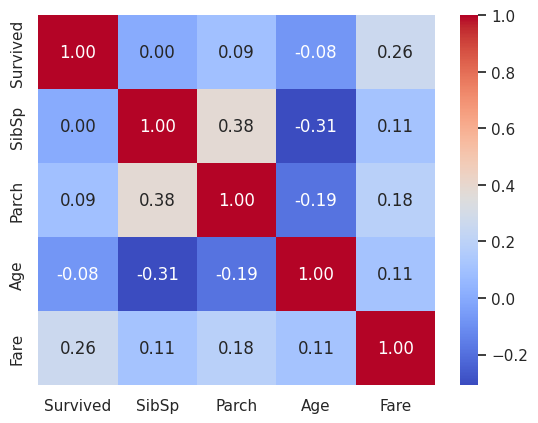

In [12]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt = ".2f",cmap="coolwarm")

Fare만 Survived와 유의미한 상관관계가 있는 것으로 보임.

다른 feature이 유용하지 않다는 의미는 아님. 이러한 feature의 하위 모집단은 Survived와 상관관계가 있을 수 있음. 이를 결정하기 위해서는 feature를 자세히 살펴봐야함.

### 3-1-1. SibSp

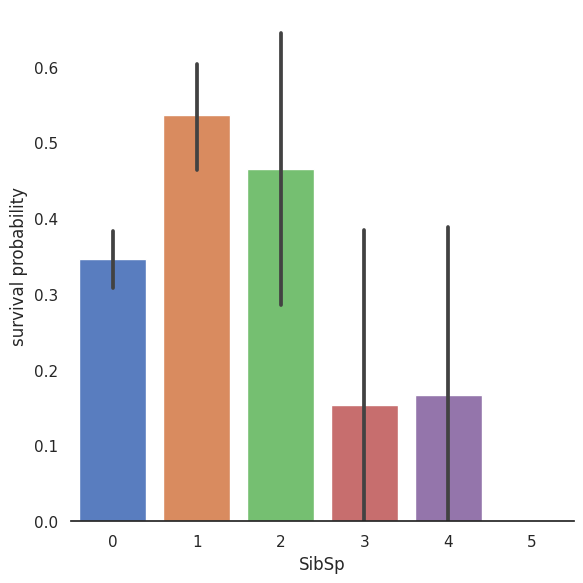

In [13]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar",height=6,palette="muted")
g.despine(left=True) # 위쪽 축과 오른쪽 축을 숨김.
g = g.set_ylabels("survival probability")

- 형제, 배우자가 많은 승객은 생존 가능성이 적은 것으로 보임.
- 한명의 승객(0 SibSp) 또는 다른 두명의 승객 (SibSp 1 or 2)는 생존할 확률이 높음.

### 3-1-2. Parch

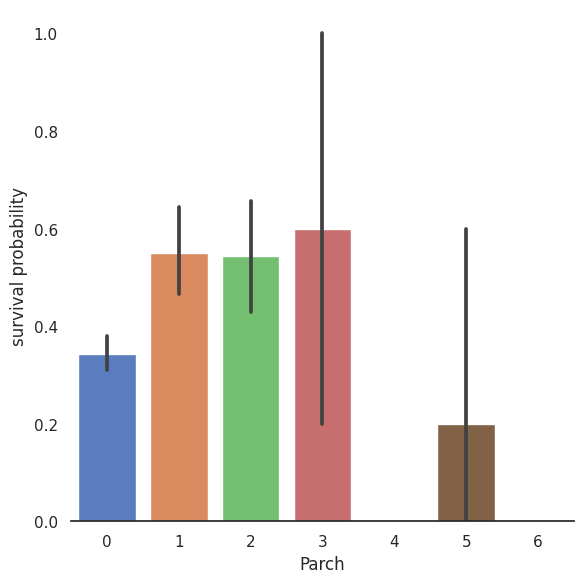

In [14]:
g = sns.catplot(x="Parch", y = "Survived", data = train, kind= "bar", height = 6, palette= "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 소규모 가족은 생존확률이 더 높음. 독신(Parch 0), 중간(Parch 3,4), 대가족(Parch 5,6)
- 부모/자녀가 3명인 승객의 생존에는 표준편차가 매우 크기 때문에 주의 해야함.

### 3-1-3. Age

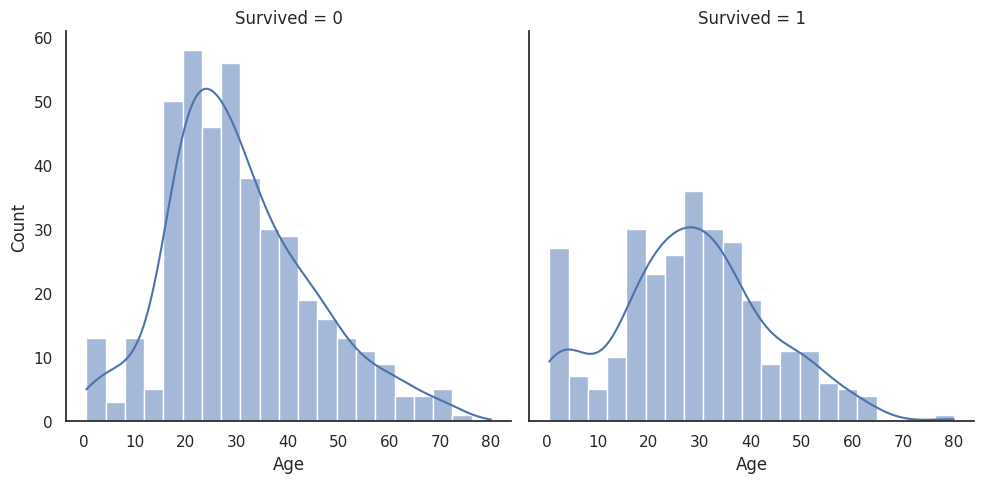

In [15]:
# Explore Age vs Survived
sns.displot(data = train, x ="Age", col = "Survived",kde = True)

- 생존한 집단과 생존하지 않은 집단의 연령 분포가 같지 않은 것을 확인할 수 있음.
- 실제로 젊은 승객에 해당하는 정점이 생존한 것으로 나타남.
- 또한 60-80세 사이의 승객이 생존한 경우가 적다는 것도 알 수 있음.
- 따라서 연령이 생존과 상관관계가 없더라도 생존 가능성이 어느 정도 높은 승객의 연령 범주가 있다는 것을 알 수 있음

- 아주 어린 승객은 생존할 수 있는 기회가 더 많은 것으로 보임.

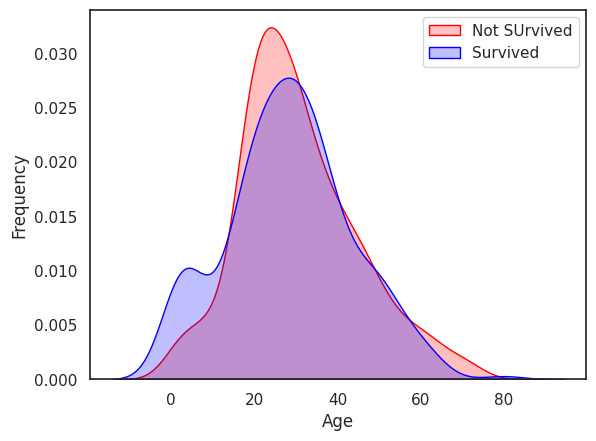

In [16]:
g = sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())],
               color = "Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())],
               color = "Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not SUrvived", "Survived"])

### 3-1-4. Fare

In [17]:
dataset["Fare"].isnull().sum()

1

In [18]:
# Fill Fare missing values with the median value

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

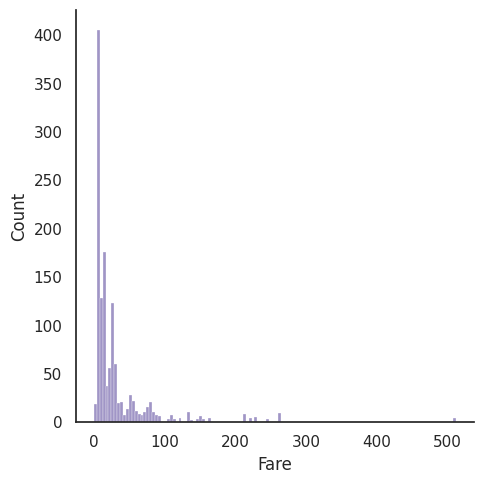

In [19]:
sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))

- Fare의 분포는 매우 왜곡되어있음. 이로 인해 규모가 축소되더라도 모델에서 가중치가 매우 높을 수 있음.
- 로그 함수로 변환하여 왜곡을 줄이는 것이 좋음.

In [20]:
# Apply log to Fare to reduce skewness distribution

dataset["Fare"] = dataset["Fare"].map(lambda i :np.log(i) if i >0 else 0)

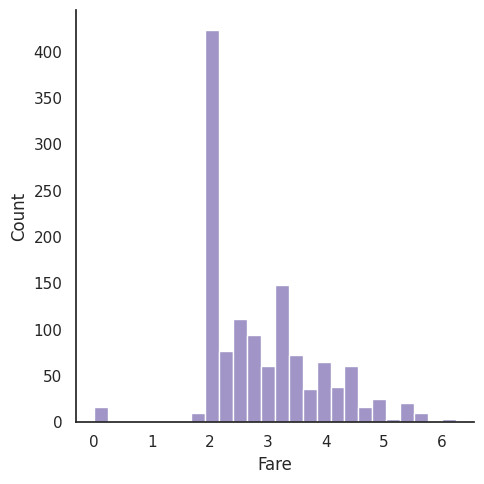

In [21]:
sns.displot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))

- 왜도가 확실히 감소한 것을 볼 수 있음.

## 3-2. Categorical values

### 3-2-1. Sex

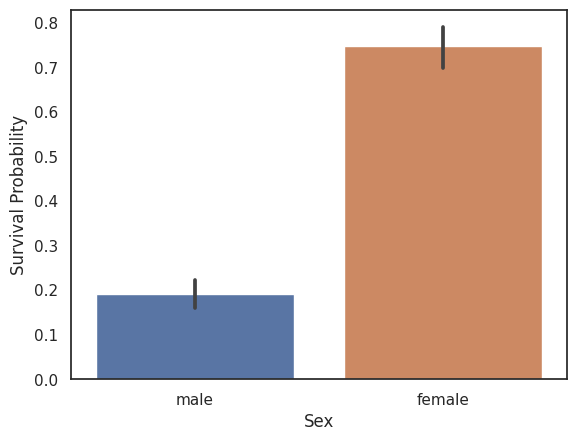

In [22]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

In [23]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성보다 여성이 훨씬 더 생존확률이 높은 것을 확인 할 수 있음.

### 3-2-2. Pclass

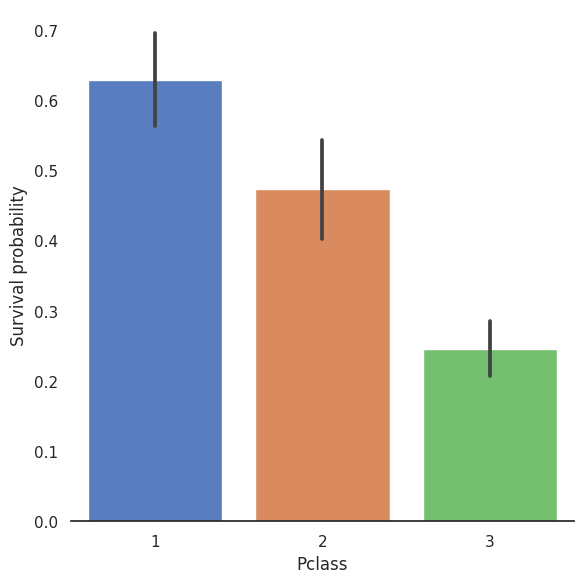

In [24]:
g = sns.catplot(x="Pclass",y="Survived",data = train,kind="bar",height=6,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

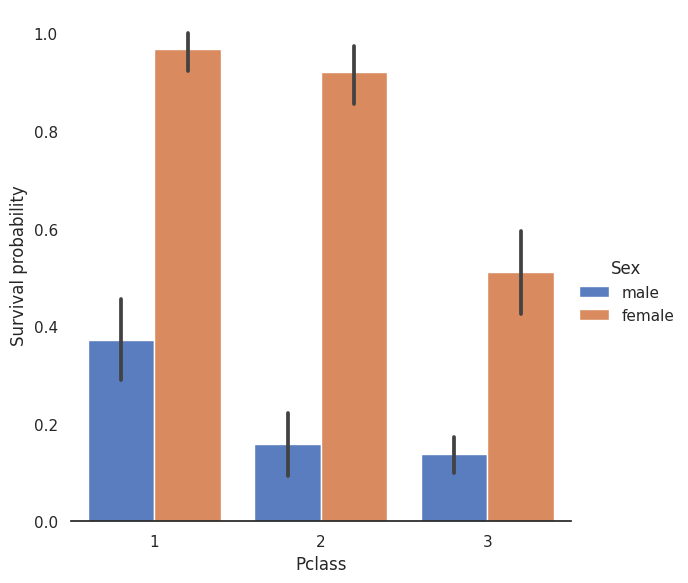

In [25]:
g = sns.catplot(x="Pclass",y="Survived",hue="Sex",data=train,height=6,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- 1등석 탑승객의 생존확률이 다른 칸보다 높음.
- 여성과 남성 모두 해당됨.

### 3-2-3. Embarked

In [26]:
dataset["Embarked"].isnull().sum()

2

In [27]:
### Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측값을 제일 최빈값인 S의 값으로 채워줌

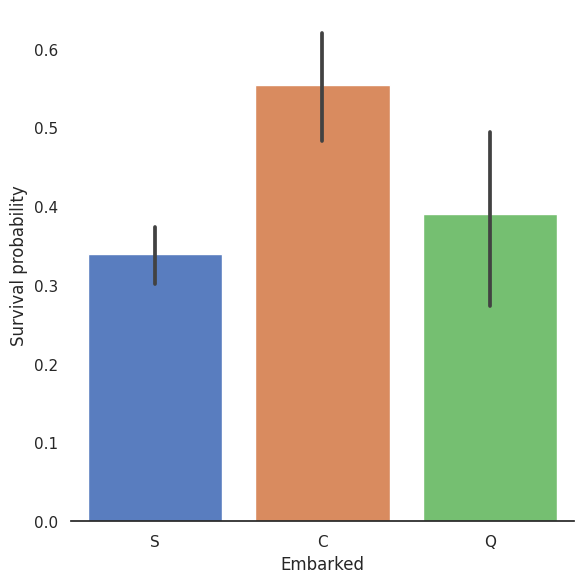

In [28]:
# Explore Embarked vs Survived

g = sns.catplot(x="Embarked",y="Survived",data = train, height=6,kind="bar",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival probability")

- C에서 탑승한 승객의 생존률이 높게 나타남.
- C에서 1등석 승객이 많이 탑승한 것으로 추측됨.

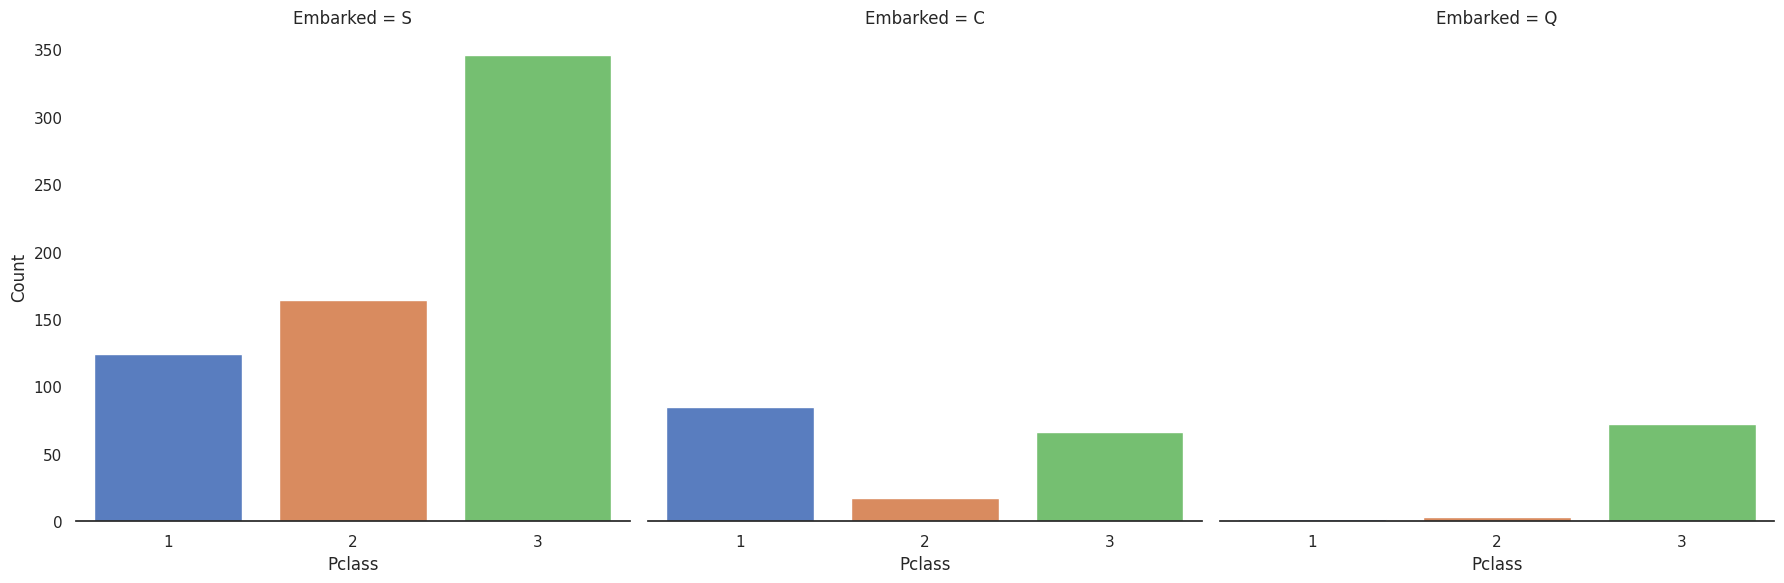

In [29]:
# Explore Pclass vs Embarked
g = sns.catplot(x="Pclass",col="Embarked",data=train,height=6,
               kind = "count",palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

- 3등석의 탑승객은 대부분 S와 Q 항구에서 탑승한것을 볼 수 있음
- C항구에서 1등석 승객의 탑승 비율이 높아서 생존확률이 높은 것으로 보임.

# 4. Filling missing values

## 4-1. Age

In [30]:
dataset['Age'].isnull().sum()

256

- Age 열은 256개의 결측값을 가지고 있음.
- 나이에 따라 생존확률이 높은 모집단이 있으므로 연령층을 유지하고 결측값을 채우는 것이 바람직할것으로 보임.
- Age와 상관관계가 큰 특성을 관찰할 필요가 있음(Sex, Parch, Pclass and SibSP)

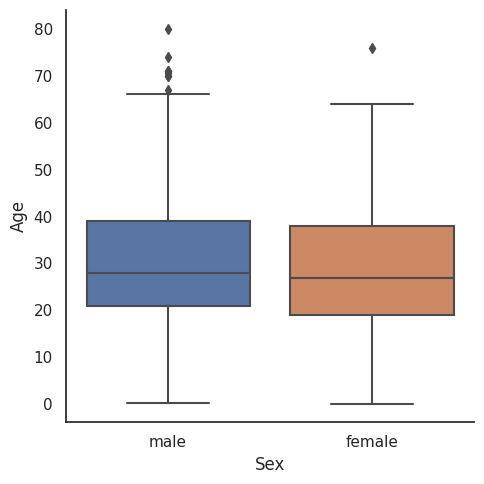

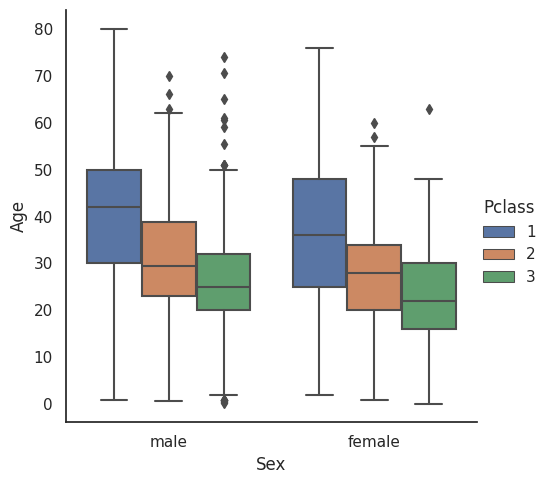

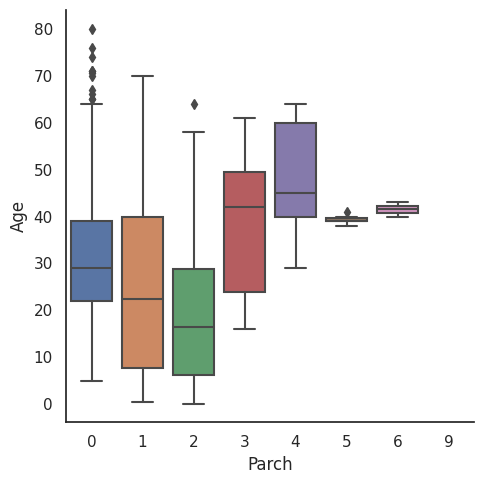

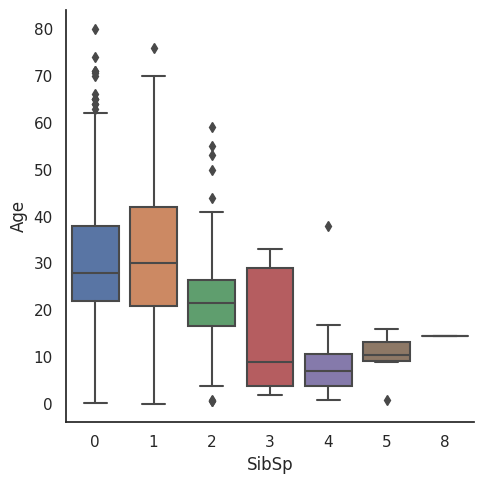

In [31]:
# Explore Age vs Sex, Parch, Pclass and SibSP

g = sns.catplot(y="Age",x="Sex",data = dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue = "Pclass",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch",data = dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp",data=dataset,kind="box")

- 연령분포는 여성과 남성에서 비슷하게 나타나므로 성별은 나이를 추측하기 중요한 특성이 아님
- 1등석 탑승자의 평균연령이 2등석, 3등석 탑승객의 나이보다 많은 것으로 보임
- 부모/자식의 수가 많을수록 평균연령이 높아지는 추세이고, 형제 자매가 많을 수록 평균연령이 낮아지는 추세임.

In [32]:
# convert Sex into categorical value 0 for male 1 for female

dataset["Sex"] = dataset["Sex"].map({"male":0,"female":1})

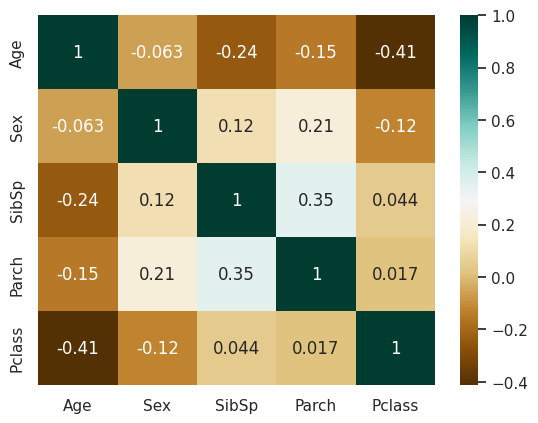

In [33]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- 연령은 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 음의 상관관계를 띄고 있음.
- Parch에 따른 연령에서 연령은 증가하는 추세를 보이지만 음의 상관관계를 가지고 있음.
- 누락된 연령 값을 대체하기 위해 SibSP, Parch, Pclass의 값을 사용하기로 함.
- Pclass, Parch, SibSp에 따라 유사한 행을 평균연령으로 채울 예정.

In [34]:
# filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp

# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"])&
                              (dataset["Parch"] == dataset.iloc[i]["Parch"]) &
                              (dataset["Pclass"] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
/tmp/ipykernel_17/1519918780.py:14: SettingWithCopyWarning: 
A value is trying to be set on

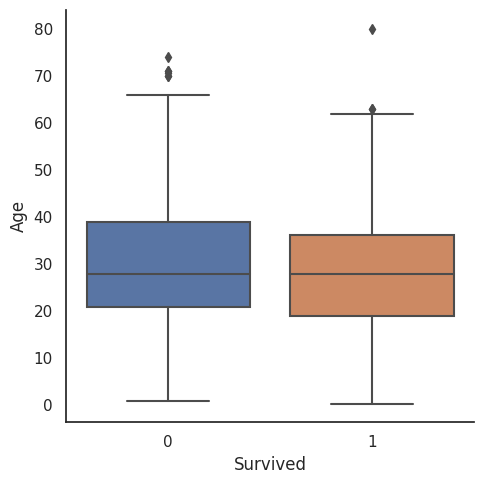

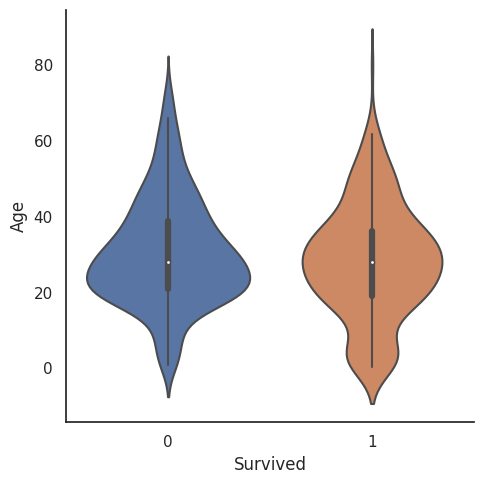

In [35]:
g = sns.catplot(x="Survived", y ="Age",data=train,kind="box")

g = sns.catplot(x="Survived",y="Age",data=train,kind="violin")

- 생존한 하위 모집단과 생존하지 못한 하위 모집단의 연령 중앙값 사이에는 차이가 없는 것으로 보임.
- 바이올린 플롯에서 보았을때는 연령이 아주 어린 탑승객의 생존률이 더 높은 것으로 보임.

# 5. Feature engineering

## 5-1. Name/Title

In [36]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- 이름에는 승객의 직함에 대한 정보가 포함되어있음
- 구조 시 특정 직함이 우선 구조가 될 가능성이 있으므로 직함을 모델에 포함시키도록함.

In [37]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

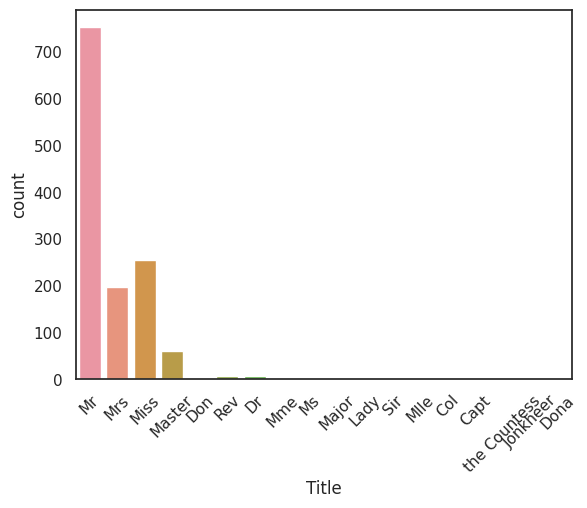

In [38]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

- 총 17개의 카테고리가 있으며 4개를 제외하고는 매우 드물게 나타나기 때문에 4개의 그룹으로 범주화 할 수 있음.

In [39]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [40]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess',
                                             'Capt', 'Col','Don', 'Dr', 'Major', 
                                             'Rev', 'Sir', 'Jonkheer', 'Dona'],
                                             'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 ,
                                         "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, 
                                         "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

In [41]:
dataset['Title'].value_counts()

Title
2    753
1    457
0     60
3     29
Name: count, dtype: int64

[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

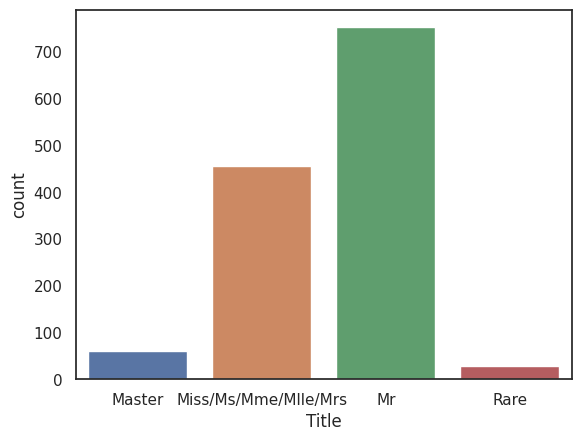

In [42]:
g= sns.countplot(x = dataset["Title"])
g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

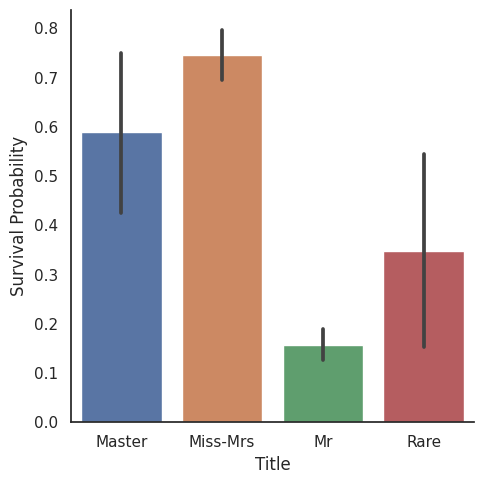

In [43]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("Survival Probability")

- 희귀한 타이틀을 가진 승객이 생존율이 높은점이 흥미로움.

In [44]:
# Drop Name variable
dataset.drop(labels = ["Name"],axis=1,inplace=True)

## 5-2. Family Size
- 대가족의 경우 그들의 형제/자매/부모를 찾는 동안 구조가 늦어질 수 있다는 점을 예상해볼 수 있음.
- Fsize(Family Size)라는 특성을 SibSp, Parch을 사용해서 만들기로 함.

In [45]:
# Create a family size descriptor from SibSp and Parch

dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


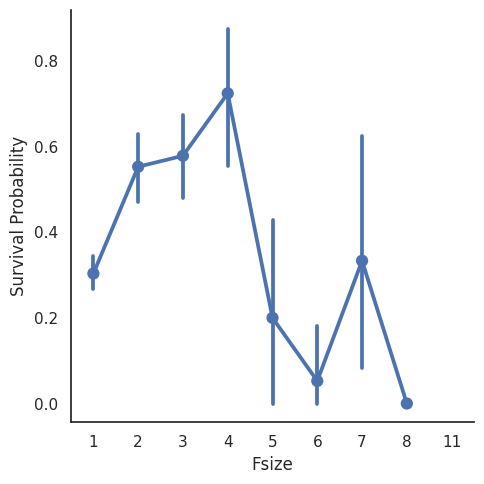

In [46]:
g = sns.catplot(x="Fsize",y="Survived",data=dataset,kind = "point")
g = g.set_ylabels("Survival Probability")

- Family Size는 중요한 역할을 하는 것으로 보임. 대가족의 경우 생존확률이 최악임.
- Family Size를 4가지 범주로 범주화.

In [47]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<= s <=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5  else 0)

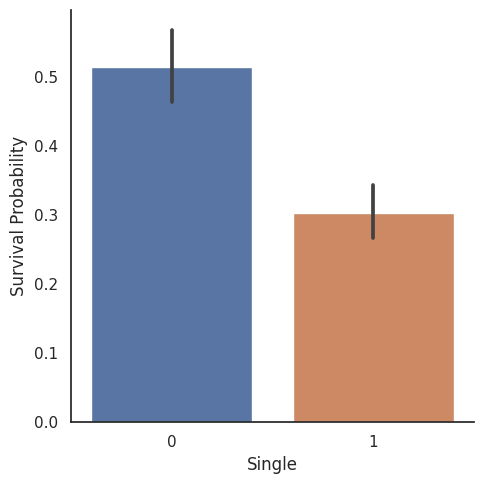

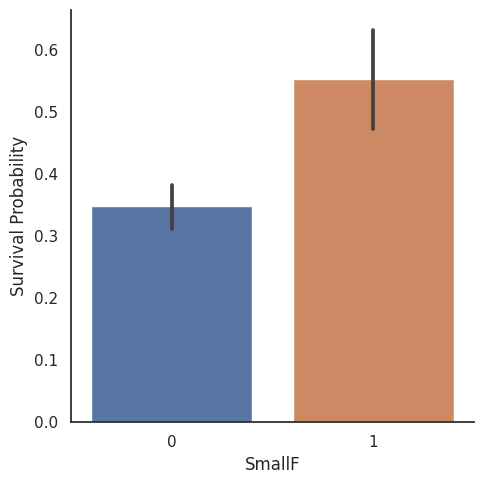

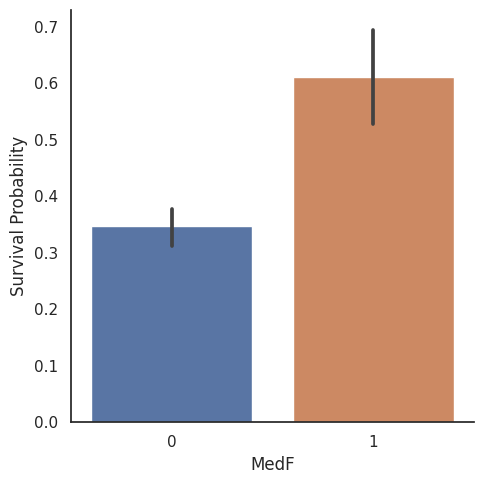

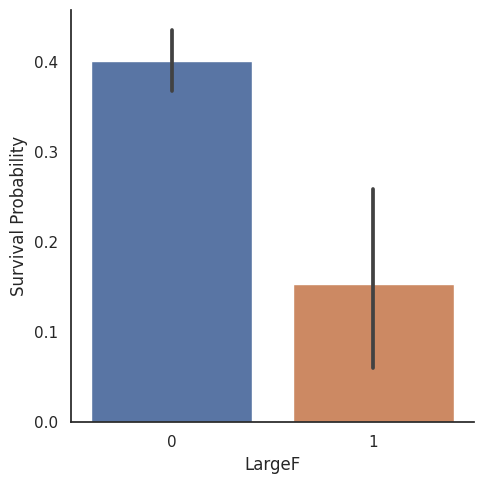

In [48]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

- 중.소형 가정이 1인가족 혹은 대가족보다 생존확률이 높은 것으로 보임.

In [49]:
# convert to indicator values Title and Embarked

dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"],prefix="Em")

In [50]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,False,False,True,False,False,False,True
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,False,True,False,False,True,False,False
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,False,True,False,False,False,False,True
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,False,True,False,False,False,False,True
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,False,False,True,False,False,False,True


## 5-3. Cabin

In [51]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [53]:
dataset["Cabin"].isnull().sum()

1007

- Cabin은 292개의 값와 1007개의 결측값으로 이루어져있음.
- 객실이 없는 승객의 경우 결측된 값으로 대체 되어 있다는 것으로 가정함.

In [54]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [55]:
# Replace the Cabin number by the type of cabin 'X' if not

dataset["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

Cabin의 첫번째 문자의 경우 Desk를 나타냄. 이 값은 타이타닉에서 승객이 어떤 위치에 탑승했는지를 확인할 수 있기 때문에 첫번째 문자만 남기기로 함.

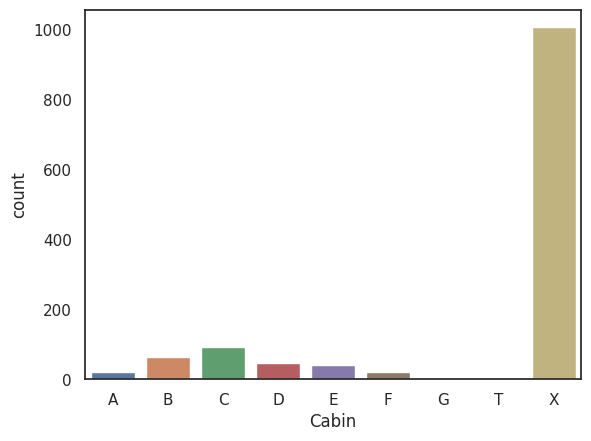

In [56]:
g = sns.countplot(x=dataset["Cabin"],order =['A','B','C','D','E','F','G','T','X'])

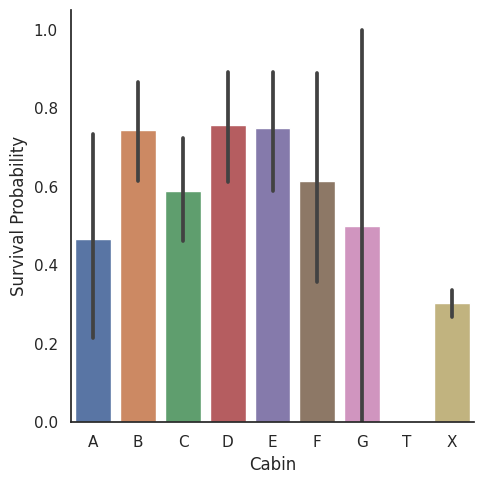

In [57]:
g = sns.catplot(x="Cabin", y ="Survived",data = dataset,kind="bar",
               order =['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

- 객실을 보유한 탑승객이 적기 때문에 생존확률은 중요한 표준편차를 가지며
- 서로 다른 데스크의 승객의 생존확률을 구분할 수 없음.
- 하지만 객실이 없는 승객보다 객실을 보유한 승객이 생존확률이 더 높은 것을 볼 수 있음.
- B, C, D, E, F에서 명확히 나타남.


In [58]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix ="Cabin")

## 5-4. Ticket

In [59]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 동일한 접두사를 공유하는 티켓을 함께 배치된 객실에 대해 예약할 수 있음을 의미함.
- 접두사가 같은 티켓은 클래스와 생존율이 비슷할 수 있음.
- 티켓열을 접두사로 바꾸기로 결정함.

In [60]:
## Treat Ticket by extracting the ticket prefix.
## When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [61]:
dataset = pd.get_dummies(dataset, columns=["Ticket"],prefix="T")

In [62]:
# Create categorical values for Pclass

dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [63]:
# Drop useless variables
dataset.drop(labels=["PassengerId"],axis=1,inplace=True)

In [64]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,False,False,False,False,False,False,False,False,False,True
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,False,False,False,False,False,False,False,True,False,False
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,False,True,False,False,False,False,False,False,False,True
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,False,False,False,False,False,False,True,True,False,False
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,False,False,False,False,False,False,True,False,False,True


# 6. Modeling

In [65]:
print("train_len :",train_len)

train_len : 881


In [66]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis=1,inplace = True)

/tmp/ipykernel_17/905793220.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"],axis=1,inplace = True)


In [67]:
train.shape, test.shape

((881, 67), (418, 66))

In [68]:
## Separate train features and label

train["Survived"] = train["Survived"].astype(int)
Y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"],axis=1)

/tmp/ipykernel_17/3448195014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


## 6-1. Simple modeling

### 6-1-1. Cross validate models
10개의 유명한 classifiers를 비교하고 계층화된 kfold 교차 검증 절차를 통해 각 classifier의 평균 정확도를 평가함

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Dis

In [69]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# target 속성값의 개수를 동일하게 분할

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

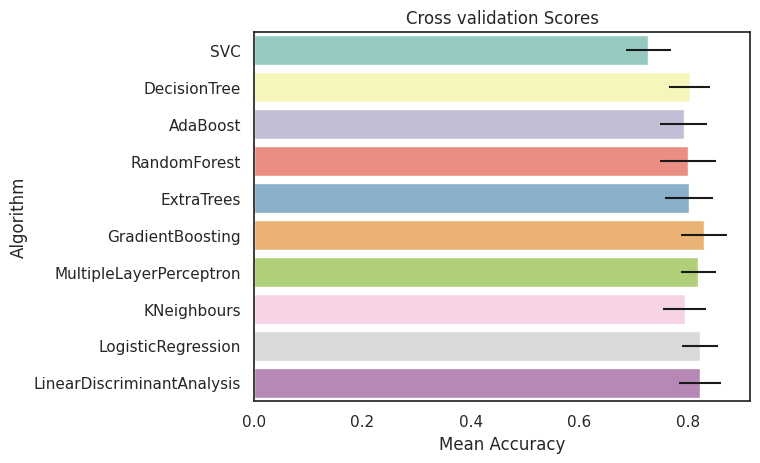

In [70]:
# Modeling step Test differents algorithms

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                     random_state = random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=Y_train,scoring="accuracy"
                                     ,cv=kfold,n_jobs=4))

cv_means= []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors":cv_std,
                      "Algorithm":["SVC","DecisionTree","AdaBoost",
                                  "RandomForest","ExtraTrees",
                                  "GradientBoosting","MultipleLayerPerceptron",
                                  "KNeighbours","LogisticRegression",
                                  "LinearDiscriminantAnalysis"]})

g = sns.barplot(x="CrossValMeans",y="Algorithm",data=cv_res,palette="Set3",
               orient="h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation Scores")

In [71]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.727617,0.041014,SVC
1,0.803728,0.038004,DecisionTree
2,0.792339,0.044264,AdaBoost
3,0.800243,0.051306,RandomForest
4,0.802541,0.044703,ExtraTrees
5,0.829724,0.041959,GradientBoosting
6,0.819535,0.032642,MultipleLayerPerceptron
7,0.794574,0.039706,KNeighbours
8,0.822932,0.033380,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting으로 앙상블 모델 만들기

### 6-1-2. Hyperparameter tunning for best models

In [72]:
### META Modeling with ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC,random_state=7)
ada_param_grid = {"base_estimator__criterion":["gini","entropy"], # 결정 트리의 분할 기준
                 "base_estimator__splitter":['best','random'], # 결정 트리에서 노드를 분할하는 방식
                 "algorithm":["SAMME","SAMME.R"], # Adaboost 알고리즘의 변형
                 "n_estimators":[1,2], # 사용할 분류기의 개수
                 "learning_rate":[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]} # 분류기의 기여도

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring="accuracy",
                       verbose=1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [73]:
print("Adaboost, best score :",gsadaDTC.best_score_)
print("Adaboost, best estimator :",gsadaDTC.best_estimator_)

Adaboost, best score : 0.8275536261491316
Adaboost, best estimator : AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.3, n_estimators=2, random_state=7)


In [74]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10], # 노드를 분할하기 위한 최소 샘플 수
                "min_samples_leaf":[1,3,10], # 리프 노드에 필요한 최소 샘플 수
                "bootstrap":[False], # 부트스트랩 샘플링을 사용할지 여부
                "n_estimators":[100,300], # 생성할 트리의 개수 설정
                "criterion":["gini"]} # 분할 품질을 평가하는 기준 설정

gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold,scoring="accuracy",
                     verbose = 1)

gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [75]:
print("ExtraTree, best score :",gsExtC.best_score_)
print("ExtraTree, best estimator :",gsExtC.best_estimator_)

ExtraTree, best score : 0.8320097037793668
ExtraTree, best estimator : ExtraTreesClassifier(max_features=3, min_samples_leaf=3)


In [76]:
# RFC parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10], # 노드를 분할하기 위한 최소 샘플 수
                "min_samples_leaf":[1,3,10], # 리프 노드에 필요한 최소 샘플 수
                "bootstrap":[False], # 부트스트랩 샘플링을 사용할지 여부
                "n_estimators":[100,300], # 생성할 트리의 개수 설정
                "criterion":["gini"]}  # 분할 품질을 평가하는 기준 설정


gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid,cv=kfold,
                     scoring="accuracy",verbose=1)

gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [77]:
print("RandomForest, best score :",gsRFC.best_score_)
print("RandomForest, best estimator :",gsRFC.best_estimator_)

RandomForest, best score : 0.8354443309499489
RandomForest, best estimator : RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=300)


In [78]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

0.8342696629213483

In [79]:
print("GradientBoosting, best score :",gsGBC.best_score_)
print("GradientBoosting, best estimator :",gsGBC.best_estimator_)

GradientBoosting, best score : 0.8342696629213483
GradientBoosting, best estimator : GradientBoostingClassifier(loss='deviance', max_depth=8, max_features=0.3,
                           min_samples_leaf=100, n_estimators=300)


In [80]:
### SCV Classifier
SVMC = SVC(probability=True)
svc_param_grid= {'kernel':['rbf'],
                'gamma':[0.001,0.01,0.1,1],
                'C':[1,10,50,100,200,300,1000]}
gsSVMC = GridSearchCV(SVMC,param_grid=svc_param_grid,cv=kfold,scoring="accuracy",
                     verbose=1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [81]:
print("SVC, best score :",gsSVMC.best_score_)
print("SVC, best estimator :",gsSVMC.best_estimator_)

SVC, best score : 0.8331332992849847
SVC, best estimator : SVC(C=10, gamma=0.01, probability=True)


### 6-1-3. Plot learning curves

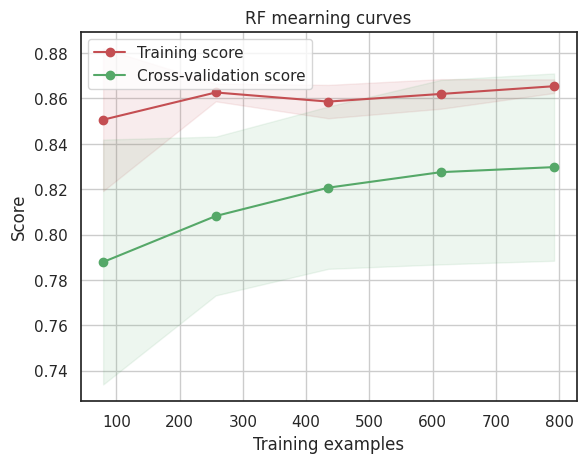

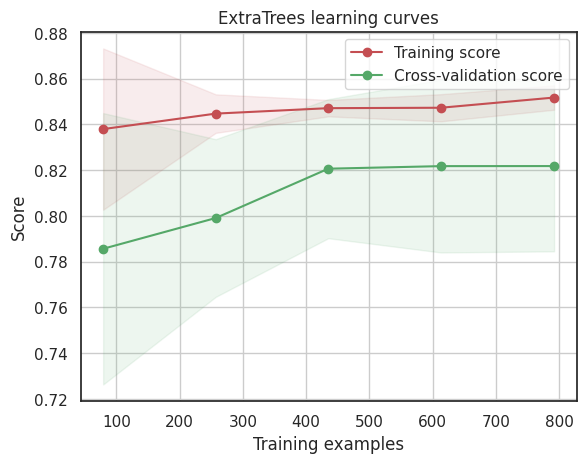

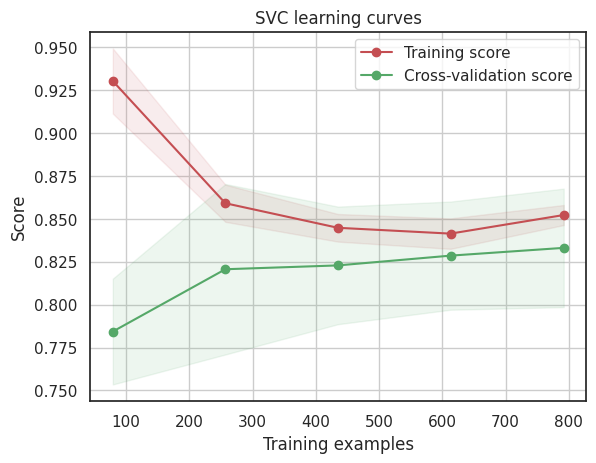

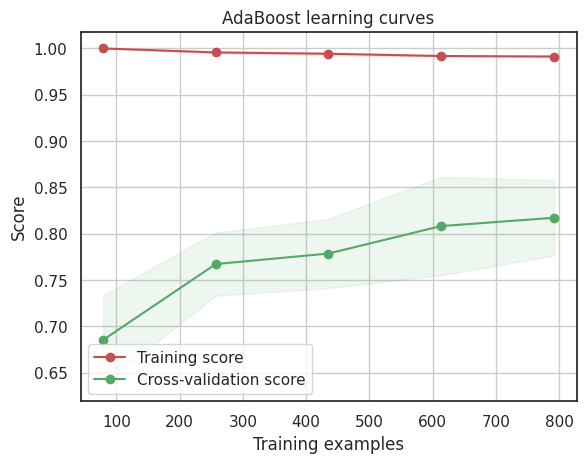

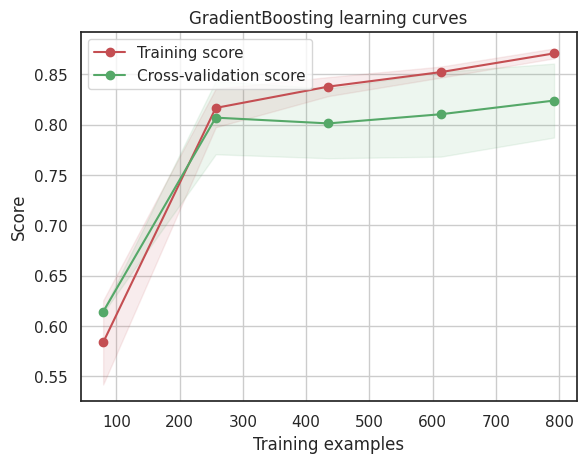

In [82]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=1, train_sizes=np.linspace(.1,1.0,5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # 평균 ± 표준 편차 범위를 신뢰 구간으로 시각화.
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- Adaboost 는 훈련세트에 과적합되는 경향이 있음.
- 증가하는 교차검증 곡선에 따르면 Adaboost는 더 많은 train data를 통해 더 나은 성과를 얻을 수 있을 것임.
- SVC, ExtraTress는 학습 곡선과 교차 검증 곡선이 서로 가깝기 때문에 예측을 더 잘 일반화하는 것으로 보임.

### 6-1-4. Feature importance of tree based classifiers
예측에 도움이 되는 feature을 확인하기 위해 4가지 트리 기반 분류기의 기능 feature 중요도를 표시

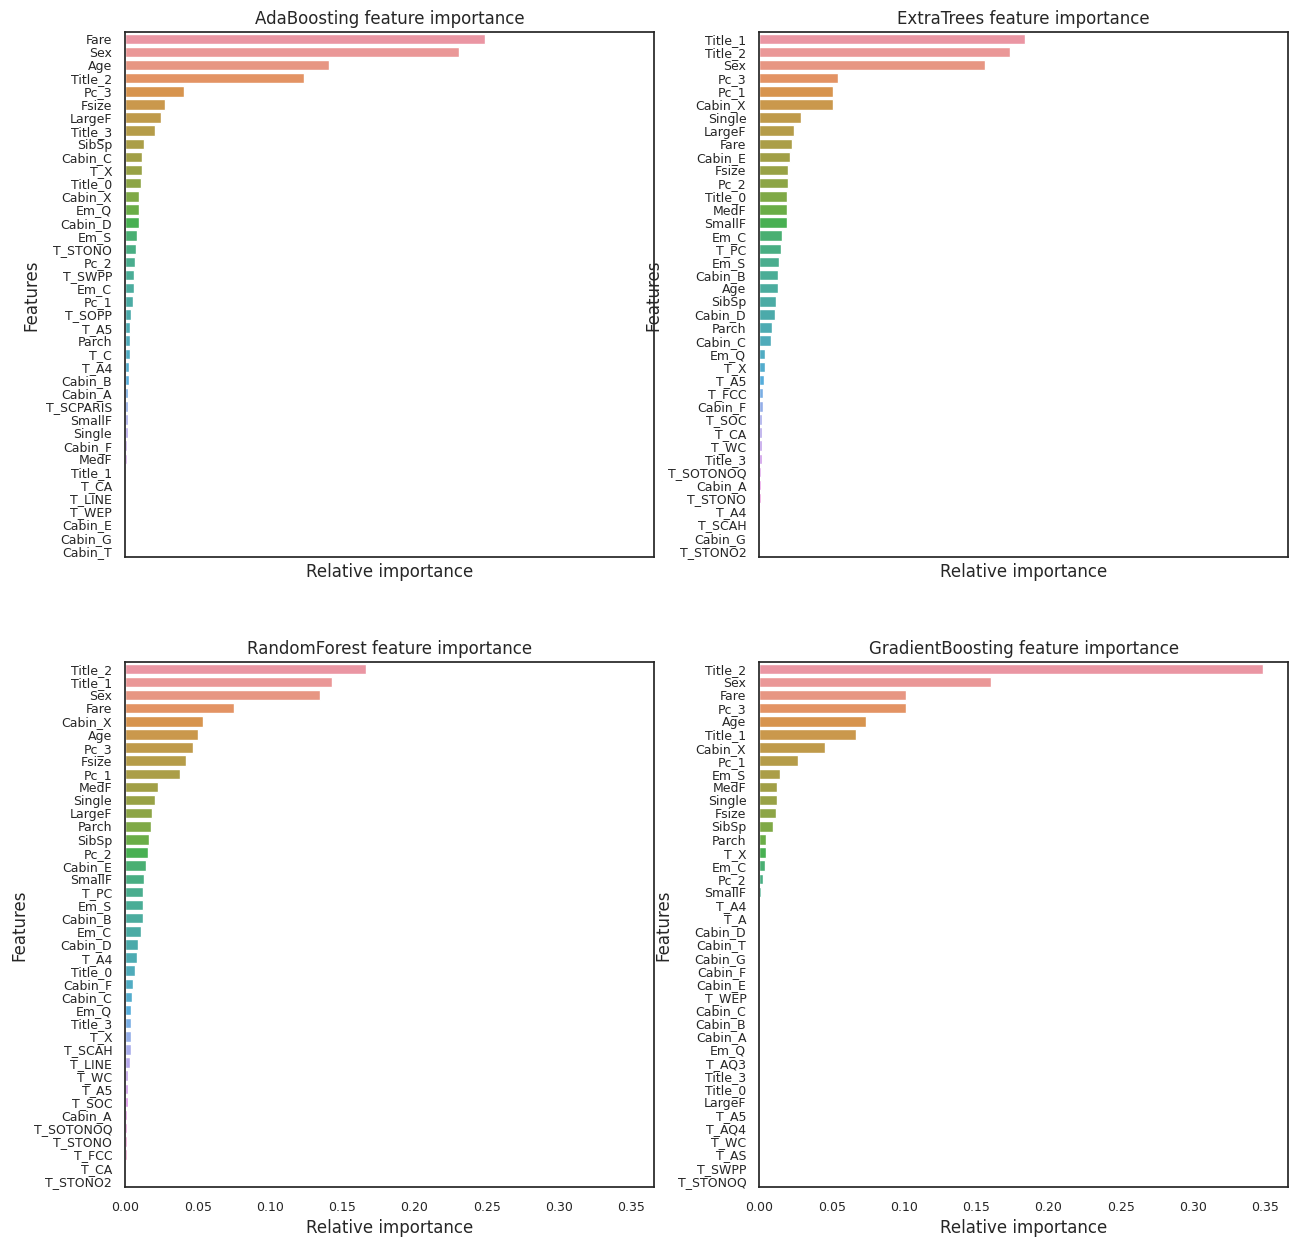

In [83]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- 네가지 분류기는 상대적 중요도에 따라 상위 feature가 다르게 나타남
- 이는 예측이 동일한 feature를 기반으로 이루어지지 않는 다는 것을 의미함.
- 그럼에도 Fare, Title_2, Age, Sex 등 분류에 사용되는 몇가지 공통적인 feature를 공유함.

- Title_2는 Sex와 높은 상관관계가 있음을 나타냄.
- Pc_1, Pc_2, Pc_3 및 Fare은 승객의 일반적인 사회적 지위를 의미함.
- Sex 및 Title_2(Mrs/Mlle/Mme/Miss/Ms)와 Title_3(Mr)은 성별을 의미함.
- Age 및 Title_1(Master)은 승객의 연령을 나타냄.
- Fsize, LargeF, MedF, Single은 승객 가족의 크기를 나타냄.

이 4가지 분류의 특징적인 중요성에 따르면, 생존 예측은 보트 안의 위치보다는 연령, 성별, 가족 규모 및 승객의 사회적 지위와 더 관련이 있는 것으로 보임것으로 보입니다.

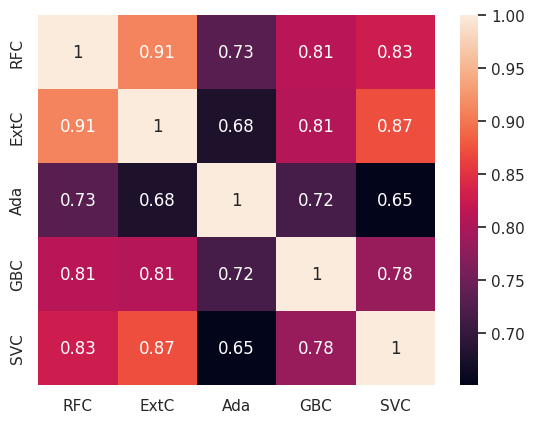

In [84]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

- 5개의 분류군에 대한 예측은 Adaboost를 다른 분류군과 비교했을 때를 제외하면 상당히 유사한것으로 보임.

- 5개의 분류기는 어느정도 동일한 예측을 제공하지만 몇가지 차이점이 있음.
- 5개의 분류기 예측간위 차이점은 앙상블 투표를 고려하기에 충분함.

## 6-2. Ensemble modeling

In [85]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best),('extc',ExtC_best),
                                     ('scv',SVMC_best),('adac',ada_best),
                                     ('gbc',GBC_best)],voting='soft',
                                     n_jobs=-1)

votingC = votingC.fit(X_train,Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


## 6-3. Prediction

### 6-3-1. Predict and Submit results

In [86]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [87]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [88]:
results.to_csv("./submission.csv",index=False)